# Importing the Dependencies

In [1]:
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from wordcloud import WordCloud
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# LOAD DATASET

In [6]:
# music.zip file downloaded from Kaggle
with zipfile.ZipFile('./data/music.zip', 'r') as zip_ref:
    zip_ref.extractall('data')

In [8]:
df = pd.read_csv('.\data\spotify_millsongdata.csv') 

# Understanding

In [9]:
df.head()

,artist,song,link,text
0,ABBA,Ahe's My Kind Of Girl,/a/abba/ahes+my+kind+of+girl_20598417.html,"Look at her face, it's a wonderful face \r\nA..."
1,ABBA,"Andante, Andante",/a/abba/andante+andante_20002708.html,"Take it easy with me, please \r\nTouch me gen..."
2,ABBA,As Good As New,/a/abba/as+good+as+new_20003033.html,I'll never know why I had to go \r\nWhy I had...
3,ABBA,Bang,/a/abba/bang_20598415.html,Making somebody happy is a question of give an...
4,ABBA,Bang-A-Boomerang,/a/abba/bang+a+boomerang_20002668.html,Making somebody happy is a question of give an...


In [10]:
df.shape

(57650, 4)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57650 entries, 0 to 57649
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   artist  57650 non-null  object
 1   song    57650 non-null  object
 2   link    57650 non-null  object
 3   text    57650 non-null  object
dtypes: object(4)
memory usage: 1.8+ MB


In [12]:
df.isnull().sum()

artist    0
song      0
link      0
text      0
dtype: int64

In [13]:
# Top artists and songs
top_artists = df['artist'].value_counts().head(10)
print("Top 10",top_artists)


Top 10 artist
Donna Summer        191
Gordon Lightfoot    189
Bob Dylan           188
George Strait       188
Loretta Lynn        187
Alabama             187
Cher                187
Reba Mcentire       187
Chaka Khan          186
Dean Martin         186
Name: count, dtype: int64


In [14]:
#Lấy 28000 bài hát vì dữ liệu quá lớn để tính consine similarity
df = df.sample(28000)

df=df.drop('link', axis=1).reset_index(drop=True)

In [15]:
df.head()

,artist,song,text
0,Maroon 5,Wipe Your Eyes,I'm afraid that I gotta do what I gotta do \r...
1,Yoko Ono,I'm Losing You,Here in some stranger's room \r\nLate in the ...
2,America,Call Of The Wild,Come save me \r\nFrom things I shouldn't do ...
3,Styx,Unfinished Song,Written by Dennis DeYoung \r\nLead vocals by ...
4,The Jam,Monday,Rainclouds came and stole my thunder \r\nLeft...


In [16]:
# WordCloud for song lyrics
all_lyrics = " ".join(df['text'].dropna())
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(all_lyrics)

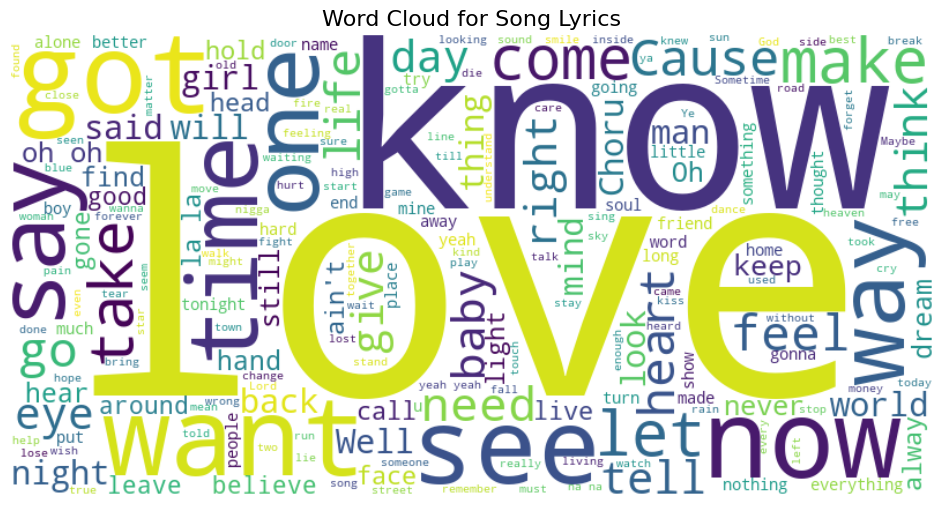

In [17]:
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud for Song Lyrics", fontsize=16)
plt.show()

# Data Preprocessing


In [18]:
# download nltk data
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to C:\Users\THINKPAD
[nltk_data]     T460\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to C:\Users\THINKPAD
[nltk_data]     T460\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\THINKPAD
[nltk_data]     T460\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [19]:
stop_words = set(stopwords.words('english'))

In [20]:
def preprocess_text(text):
    # Remove special characters and numbers
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    # Convert to lowercase
    text = text.lower()
    # Tokenize and remove stopwords
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return " ".join(tokens)

In [21]:
df['cleaned_text'] = df['text'].apply(preprocess_text)

In [22]:
df.head()

,artist,song,text,cleaned_text
0,Maroon 5,Wipe Your Eyes,I'm afraid that I gotta do what I gotta do \r...,im afraid got ta got ta let go gon na go got t...
1,Yoko Ono,I'm Losing You,Here in some stranger's room \r\nLate in the ...,strangers room late afternoon aint doubt im lo...
2,America,Call Of The Wild,Come save me \r\nFrom things I shouldn't do ...,come save things shouldnt need every word true...
3,Styx,Unfinished Song,Written by Dennis DeYoung \r\nLead vocals by ...,written dennis deyoung lead vocals dennis deyo...
4,The Jam,Monday,Rainclouds came and stole my thunder \r\nLeft...,rainclouds came stole thunder left barren like...


In [23]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
tfidf_matrix = tfidf_vectorizer.fit_transform(df['cleaned_text'])

In [25]:
print(tfidf_matrix.shape)

(28000, 5000)


In [26]:
sim_scores = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [27]:
def recommend_song(input_title,sim_scores=sim_scores, df=df, top_k=5):
    # Lấy chỉ số bài hát đầu vào
    idx = df[df['song'].str.lower() == input_title.lower()].index
    # Kiểm tra input có trong dataset không
    if len(idx) == 0:
        return f"Song '{input_title}' not found in the  trong dataset."
    idx = idx[0]

    # Lấy điểm tương đồng của bài hát đầu vào với tất cả các bài hát khác
    sim_scores = list(enumerate(sim_scores[idx]))

    # Lấy top_k bài hát tương đồng nhất, loại trừ chính nó
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_k+1]

    # Lấy chỉ số bài hát tương đồng nhất
    song_indices = [i[0] for i in sim_scores]
    
    # Trả về danh sách bài hát gợi ý
    recommendations = df[['song', 'artist']].iloc[song_indices]
    return recommendations

In [28]:
df.head()

,artist,song,text,cleaned_text
0,Maroon 5,Wipe Your Eyes,I'm afraid that I gotta do what I gotta do \r...,im afraid got ta got ta let go gon na go got t...
1,Yoko Ono,I'm Losing You,Here in some stranger's room \r\nLate in the ...,strangers room late afternoon aint doubt im lo...
2,America,Call Of The Wild,Come save me \r\nFrom things I shouldn't do ...,come save things shouldnt need every word true...
3,Styx,Unfinished Song,Written by Dennis DeYoung \r\nLead vocals by ...,written dennis deyoung lead vocals dennis deyo...
4,The Jam,Monday,Rainclouds came and stole my thunder \r\nLeft...,rainclouds came stole thunder left barren like...


In [32]:
# Example Recommendation
print("\nRecommendations for the song :")
recommendations = recommend_song("I'm Losing You",top_k=10)
print(recommendations)


Recommendations for the song :
                             song             artist
13571             Losing My Touch     Rolling Stones
21578              I'm Losing You        Rod Stewart
6187               Losing My Mind      Pet Shop Boys
3990                Losing Things    Beautiful South
8871         I'm Not Losing Sleep        David Bowie
8953       Can't Stand Losing You              Sting
24666                  Losing You  Dusty Springfield
1308                 Losing Touch       Indigo Girls
1402              Punishment Time               Korn
3809   Script For A Jester's Tear          Marillion


In [31]:
import joblib
df.to_csv("./data/cleaned_songs.csv", index=False)
joblib.dump(tfidf_vectorizer, './models/tfidf_vectorizer.pkl')
joblib.dump(tfidf_matrix, './models/tfidf_matrix.pkl')
joblib.dump(sim_scores, './models/cosine_sim.pkl')

['./models/cosine_sim.pkl']